In [78]:
!pip install umap-learn

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score, adjusted_rand_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import umap
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.19.0


In [79]:
# ========================================
# CELL 2: Load and Explore Data
# ========================================


# Load your files
dataset = pd.read_csv('/content/drive/MyDrive/24341180_425Project/dataset.csv')  # Path to dataset.csv
processed_ids = np.load('/content/drive/MyDrive/24341180_425Project/processed_ids.npy')
spectrogram_data = np.load('/content/drive/MyDrive/24341180_425Project/processed_spectrograms.npy')

# Filter the dataset to match the processed IDs
dataset_filtered = dataset[dataset['id'].isin(processed_ids)].reset_index(drop=True)

# Ensure the order of dataset_filtered matches processed_ids if necessary
# This step is crucial for correct label alignment
id_to_index = {id_val: i for i, id_val in enumerate(processed_ids)}
dataset_filtered = dataset_filtered.set_index('id').loc[processed_ids].reset_index()

print("=" * 60)
print("DATA OVERVIEW")
print("=" * 60)
print(f"Original Dataset shape: {dataset.shape}")
print(f"Filtered Dataset shape: {dataset_filtered.shape}")
print(f"Processed data shape: {processed_ids.shape}")
print(f"Spectrogram shape: {spectrogram_data.shape}")
print(f"\nFiltered Dataset columns: {dataset_filtered.columns.tolist()}")
print(f"\nFirst few rows of filtered dataset:")
print(dataset_filtered.head())

# Check if there are labels for ARI calculation
has_labels = 'label' in dataset_filtered.columns or 'genre' in dataset_filtered.columns or 'language' in dataset_filtered.columns
if has_labels:
    label_col = 'label' if 'label' in dataset_filtered.columns else ('genre' if 'genre' in dataset_filtered.columns else 'language')
    true_labels = dataset_filtered[label_col].values
    print(f"\nFound labels in column: {label_col} for filtered dataset")
    print(f"Unique labels: {np.unique(true_labels)}")
    print(f"Number of true labels: {len(true_labels)}")
else:
    true_labels = None
    print("\nNo labels found. ARI will not be computed.")

# Verify lengths are now consistent
if true_labels is not None and len(true_labels) != spectrogram_data.shape[0]:
    raise ValueError("Mismatch in lengths after filtering true_labels! Check data consistency.")
else:
    print("\nTrue labels length is consistent with processed data.")

DATA OVERVIEW
Original Dataset shape: (796, 5)
Filtered Dataset shape: (683, 5)
Processed data shape: (683,)
Spectrogram shape: (683, 128, 256)

Filtered Dataset columns: ['id', 'title', 'audio_path', 'genre', 'lyrics']

First few rows of filtered dataset:
       id                    title  \
0   82203                Beers Ago   
1  445332               Have Mercy   
2  541844  Memphis in the Meantime   
3  228626       Good Hearted Woman   
4   73111          I Walk The Line   

                                          audio_path    genre  \
0             data/audio/Beers Ago [Hosifr6ycwU].wav  country   
1  data/audio/What a Friend We Have in Jesus [ttN...  country   
2  data/audio/Memphis In The Meantime [KxhE-2apva...  country   
3  data/audio/A Good Hearted Woman (Live at Weste...  country   
4       data/audio/I Walk the Line [J-6fW66IUY4].wav  country   

                                              lyrics  
0  [Verse 1]\nI had a hand-me-down ride painted r...  
1  Have mercy

In [80]:
# ========================================
# CELL 3: Prepare Spectrogram Data for CNN
# ========================================
# Reshape spectrogram for convolutional layers
# Assuming spectrogram_data is (n_samples, time_steps, freq_bins) or needs reshaping

# Check current shape
print("\nOriginal spectrogram shape:", spectrogram_data.shape)

# If it's 2D, we need to infer the proper shape
if len(spectrogram_data.shape) == 2:
    # Common spectrogram dimensions
    n_samples = spectrogram_data.shape[0]
    feature_length = spectrogram_data.shape[1]

    # Try to reshape to something reasonable (e.g., square-ish)
    # Example: if feature_length = 128*128 = 16384, reshape to (128, 128)
    import math
    sqrt_dim = int(math.sqrt(feature_length))

    if sqrt_dim * sqrt_dim == feature_length:
        time_steps = freq_bins = sqrt_dim
    else:
        # Default to common spectrogram dimensions
        freq_bins = 128  # Mel bands
        time_steps = feature_length // freq_bins

    spec_data_reshaped = spectrogram_data.reshape(n_samples, time_steps, freq_bins, 1)
else:
    spec_data_reshaped = spectrogram_data
    if len(spec_data_reshaped.shape) == 3:
        spec_data_reshaped = np.expand_dims(spec_data_reshaped, axis=-1)

print(f"Reshaped spectrogram: {spec_data_reshaped.shape}")

# Normalize to [0, 1] for binary crossentropy and sigmoid output
# This assumes spectrogram values are non-negative intensities.
min_val = np.min(spec_data_reshaped)
max_val = np.max(spec_data_reshaped)
spec_data_normalized = (spec_data_reshaped - min_val) / (max_val - min_val + 1e-8)



Original spectrogram shape: (683, 128, 256)
Reshaped spectrogram: (683, 128, 256, 1)


In [81]:
# ========================================
# CELL 4: Prepare Lyrics Embeddings (if available)
# ========================================
# Check if lyrics embeddings exist
import os
lyrics_path = '/content/drive/MyDrive/24341180_425Project/Copy of lyrics_embeddings.npy'

if os.path.exists(lyrics_path):
    lyrics_embeddings = np.load(lyrics_path)
    print(f"\nLyrics embeddings shape: {lyrics_embeddings.shape}")
    lyrics_embeddings_normalized = StandardScaler().fit_transform(lyrics_embeddings)
    use_lyrics = True
else:
    print("\nNo lyrics embeddings found. Creating dummy embeddings from preprocessed data...")
    # Create synthetic lyrics embeddings from preprocessed data
    # In real scenario, use BERT, Word2Vec, or TF-IDF on lyrics
    lyrics_embeddings_normalized = StandardScaler().fit_transform(preprocessed_data[:, :300] if preprocessed_data.shape[1] > 300 else preprocessed_data)
    use_lyrics = True

print(f"Using lyrics embeddings: {use_lyrics}")


Lyrics embeddings shape: (683, 384)
Using lyrics embeddings: True


In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
# ========================================
# CELL 5: Build Convolutional VAE for Spectrograms
# ========================================
latent_dim = 64

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder with Convolutional Layers
input_shape = spec_data_normalized.shape[1:]  # (time_steps, freq_bins, 1)
print(f"\nBuilding Conv-VAE with input shape: {input_shape}")

encoder_inputs = keras.Input(shape=input_shape)

# Convolutional encoder layers
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)

# Flatten
shape_before_flattening = x.shape[1:]
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)

# Latent space
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var]) # Sampled latent vector

conv_encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='conv_encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512, activation='relu')(latent_inputs)
x = layers.Dense(np.prod(shape_before_flattening), activation='relu')(x)
x = layers.Reshape(shape_before_flattening)(x)

# Deconvolutional layers
x = layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

conv_decoder = Model(latent_inputs, decoder_outputs, name='conv_decoder')

# Custom Conv-VAE class encapsulating encoder and decoder
class ConvVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        # The VAE's call method will process input through encoder and decoder
        # but the actual loss calculation happens in train_step
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = keras.ops.mean(
                keras.ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * keras.ops.mean(
                keras.ops.sum(
                    1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                    axis=1
                )
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = keras.ops.mean(
            keras.ops.sum(
                keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2)
            )
        )
        kl_loss = -0.5 * keras.ops.mean(
            keras.ops.sum(
                1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                axis=1
            )
        )
        total_loss = reconstruction_loss + kl_loss
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Building Conv-VAE with input shape: (128, 256, 1)


In [84]:
import os

# Define the new base path for results
base_path = '/content/drive/MyDrive/24341180_425Project/result_2/'

# Create necessary directories
os.makedirs(base_path + 'results/metrics/', exist_ok=True)
os.makedirs(base_path + 'results/visualizations/', exist_ok=True)
os.makedirs(base_path + 'results/models/', exist_ok=True)

print(f"New base path set to: {base_path}")
print("Necessary directories created.")

New base path set to: /content/drive/MyDrive/24341180_425Project/result_2/
Necessary directories created.


In [85]:
import matplotlib.pyplot as plt

# Re-save Conv-VAE training history plot
plt.figure(figsize=(10, 5))
plt.plot(conv_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(conv_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('Convolutional VAE Training History', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(base_path + 'results/visualizations/conv_vae_training.png', dpi=300, bbox_inches='tight')
plt.close() # Close plot to prevent it from displaying again
print(f"Conv-VAE training history plot re-saved to: {base_path}results/visualizations/conv_vae_training.png")

Conv-VAE training history plot re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/visualizations/conv_vae_training.png


In [86]:
import matplotlib.pyplot as plt

# Re-save Hybrid VAE training history plot
plt.figure(figsize=(10, 5))
plt.plot(hybrid_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(hybrid_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('Hybrid VAE Training History', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(base_path + 'results/visualizations/hybrid_vae_training.png', dpi=300, bbox_inches='tight')
plt.close() # Close plot to prevent it from displaying again
print(f"Hybrid VAE training history plot re-saved to: {base_path}results/visualizations/hybrid_vae_training.png")

Hybrid VAE training history plot re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/visualizations/hybrid_vae_training.png


In [87]:
import pandas as pd

# Re-save comprehensive metrics to CSV
results_df.to_csv(base_path + 'results/metrics/comprehensive_metrics.csv', index=False)
print(f"Comprehensive metrics re-saved to: {base_path}results/metrics/comprehensive_metrics.csv")

Comprehensive metrics re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/metrics/comprehensive_metrics.csv


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Silhouette Score
pivot_sil = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Silhouette_Score')
pivot_sil.plot(kind='bar', ax=axes[0, 0], rot=0)
axes[0, 0].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].legend(title='Algorithm', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Davies-Bouldin Index
pivot_db = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Davies_Bouldin_Index')
pivot_db.plot(kind='bar', ax=axes[0, 1], rot=0, color=['#ff9999', '#66b3ff', '#99ff99'])
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].legend(title='Algorithm', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz Index
pivot_ch = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Calinski_Harabasz_Index')
pivot_ch.plot(kind='bar', ax=axes[1, 0], rot=0, color=['#ffcc99', '#ff99cc', '#99ccff'])
axes[1, 0].set_title('Calinski-Harabasz Index (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].legend(title='Algorithm', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# ARI (if available)
if results_df['ARI'].dtype != 'object':
    pivot_ari = results_df.pivot(index='Feature_Set', columns='Algorithm', values='ARI')
    pivot_ari.plot(kind='bar', ax=axes[1, 1], rot=0, color=['#c2c2f0', '#ffb3e6', '#c2f0c2'])
    axes[1, 1].set_title('Adjusted Rand Index (Higher is Better)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].legend(title='Algorithm', fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'ARI Not Available\n(No Ground Truth Labels)',
                    ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.close()
print(f"Metrics comparison plot re-saved to: {base_path}results/visualizations/metrics_comparison.png")

Metrics comparison plot re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/visualizations/metrics_comparison.png


In [89]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import numpy as np

# Assuming feature_sets and best_methods are available from previous execution
# Re-generate t-SNE plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # Adjust for 2 feature sets

for idx, (feat_name, features) in enumerate(feature_sets.items()):
    # Get best algorithm for this feature set
    best_algo_name = best_methods[feat_name]['Algorithm']

    # Recreate clustering
    if best_algo_name == 'K-Means':
        algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    elif best_algo_name == 'Agglomerative':
        algo = AgglomerativeClustering(n_clusters=n_clusters)
    else:  # DBSCAN
        algo = DBSCAN(eps=0.5, min_samples=5)

    clusters = algo.fit_predict(features)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
    tsne_features = tsne.fit_transform(features)

    # Plot
    scatter = axes[idx].scatter(tsne_features[:, 0], tsne_features[:, 1],
                                c=clusters, cmap='tab10', alpha=0.6, s=50)
    axes[idx].set_title(f'{feat_name} + {best_algo_name}\n(Silhouette: {best_methods[feat_name]["Silhouette_Score"]:.3f})',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('t-SNE Dimension 1', fontsize=11)
    axes[idx].set_ylabel('t-SNE Dimension 2', fontsize=11)
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/tsne_best_methods.png', dpi=300, bbox_inches='tight')
plt.close()
print(f"t-SNE visualization re-saved to: {base_path}results/visualizations/tsne_best_methods.png")

t-SNE visualization re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/visualizations/tsne_best_methods.png


In [90]:
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import numpy as np

# Assuming feature_sets and best_methods are available from previous execution
# Re-generate UMAP plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # Adjust for 2 feature sets

for idx, (feat_name, features) in enumerate(feature_sets.items()):
    # Get best algorithm for this feature set
    best_algo_name = best_methods[feat_name]['Algorithm']

    # Recreate clustering
    if best_algo_name == 'K-Means':
        algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    elif best_algo_name == 'Agglomerative':
        algo = AgglomerativeClustering(n_clusters=n_clusters)
    else:  # DBSCAN
        algo = DBSCAN(eps=0.5, min_samples=5)

    clusters = algo.fit_predict(features)

    # Apply UMAP
    reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
    umap_features = reducer.fit_transform(features)

    # Plot
    scatter = axes[idx].scatter(umap_features[:, 0], umap_features[:, 1],
                                c=clusters, cmap='tab10', alpha=0.6, s=50)
    axes[idx].set_title(f'{feat_name} + {best_algo_name}\n(Silhouette: {best_methods[feat_name]["Silhouette_Score"]:.3f})',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('UMAP Dimension 1', fontsize=11)
    axes[idx].set_ylabel('UMAP Dimension 2', fontsize=11)
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/umap_best_methods.png', dpi=300, bbox_inches='tight')
plt.close()
print(f"UMAP visualization re-saved to: {base_path}results/visualizations/umap_best_methods.png")

UMAP visualization re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/visualizations/umap_best_methods.png


In [91]:
# Re-save analysis report
analysis_text = """
ANALYSIS OF VAE vs BASELINE PERFORMANCE:

1. CONVOLUTIONAL VAE:
   Strengths:
   - Captures spatial/temporal patterns in spectrograms
   - Learns hierarchical representations
   - Better at preserving local structure
   - Reduces dimensionality while maintaining information

   Weaknesses:
   - Requires more computational resources
   - May overfit on small datasets
   - Sensitive to hyperparameter choices

2. HYBRID VAE (Audio + Lyrics):
   Strengths:
   - Leverages multiple modalities
   - Captures complementary information
   - More robust to noise in single modality
   - Better semantic representation

   Weaknesses:
   - More complex training
   - Requires aligned multi-modal data
   - May be dominated by one modality if not balanced

3. PCA BASELINE:
   Strengths:
   - Fast and simple
   - Deterministic results
   - No hyperparameters to tune

   Weaknesses:
   - Linear transformation only
   - Doesn't capture non-linear patterns
   - May lose important structure
   - No generative capability

4. CLUSTERING ALGORITHM COMPARISON:
   K-Means:
   - Works well with spherical clusters
   - Fast and scalable
   - Requires predefined number of clusters

   Agglomerative:
   - Captures hierarchical structure
   - More flexible cluster shapes
   - Computationally expensive for large datasets

   DBSCAN:
   - Finds arbitrary-shaped clusters
   - Automatic outlier detection
   - Sensitive to parameter selection (eps, min_samples)
"""

with open(base_path + 'results/analysis_report.txt', 'w') as f:
    f.write(analysis_text)
    f.write("\n\nNUMERICAL RESULTS:\n")
    f.write("="*60 + "\n")
    f.write(results_df.to_string())
print(f"Analysis report re-saved to: {base_path}results/analysis_report.txt")

Analysis report re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/analysis_report.txt


In [92]:
import numpy as np

# Re-save models
conv_vae.save(base_path + 'results/models/conv_vae_model.h5')
conv_encoder.save(base_path + 'results/models/conv_encoder_model.h5')
conv_decoder.save(base_path + 'results/models/conv_decoder_model.h5')

hybrid_vae.save(base_path + 'results/models/hybrid_vae_model.h5')
hybrid_encoder.save(base_path + 'results/models/hybrid_encoder_model.h5')
hybrid_decoder.save(base_path + 'results/models/hybrid_decoder_model.h5')

print("✓ Conv-VAE models re-saved")
print("✓ Hybrid-VAE models re-saved")

# Re-save latent features
np.save(base_path + 'results/latent_features_conv.npy', z_mean_spec)
np.save(base_path + 'results/latent_features_hybrid.npy', z_mean_hybrid)
print(f"Latent features re-saved to: {base_path}results/")

✓ Conv-VAE models re-saved
✓ Hybrid-VAE models re-saved
Latent features re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/


In [93]:
import matplotlib.pyplot as plt
import numpy as np

n_samples = 5
sample_indices = np.random.choice(len(spec_data_normalized), n_samples, replace=False)

reconstructed_conv = conv_vae.predict(spec_data_normalized[sample_indices], verbose=0)

fig, axes = plt.subplots(2, n_samples, figsize=(20, 8))

for i, idx in enumerate(sample_indices):
    axes[0, i].imshow(spec_data_normalized[idx, :, :, 0], aspect='auto', cmap='viridis')
    axes[0, i].set_title(f'Original {idx}', fontsize=10)
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_conv[i, :, :, 0], aspect='auto', cmap='viridis')
    axes[1, i].set_title(f'Reconstructed {idx}', fontsize=10)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Reconstructed', fontsize=12, fontweight='bold')

plt.suptitle('Conv-VAE Reconstruction Quality', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/reconstruction_quality.png', dpi=300, bbox_inches='tight')
plt.close()
print(f"Reconstruction quality plot re-saved to: {base_path}results/visualizations/reconstruction_quality.png")

Reconstruction quality plot re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/visualizations/reconstruction_quality.png


In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Select two samples
idx1, idx2 = np.random.choice(len(z_mean_spec), 2, replace=False)
z1 = z_mean_spec[idx1]
z2 = z_mean_spec[idx2]

# Interpolate in latent space
n_steps = 10
interpolation = np.zeros((n_steps, latent_dim))
for i in range(n_steps):
    alpha = i / (n_steps - 1)
    interpolation[i] = (1 - alpha) * z1 + alpha * z2

# Decode interpolated latents
interpolated_specs = conv_decoder.predict(interpolation, verbose=0)

# Visualize interpolation
fig, axes = plt.subplots(1, n_steps, figsize=(25, 3))
for i in range(n_steps):
    axes[i].imshow(interpolated_specs[i, :, :, 0], aspect='auto', cmap='viridis')
    axes[i].set_title(f'Step {i+1}', fontsize=9)
    axes[i].axis('off')

plt.suptitle(f'Latent Space Interpolation (Sample {idx1} → Sample {idx2})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/latent_interpolation.png', dpi=300, bbox_inches='tight')
plt.close()
print(f"Latent space interpolation plot re-saved to: {base_path}results/visualizations/latent_interpolation.png")

Latent space interpolation plot re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/visualizations/latent_interpolation.png


In [95]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Use best overall method
best_feat = best_overall['Feature_Set']
best_algo = best_overall['Algorithm']
best_features = feature_sets[best_feat]

# Get clusters
if best_algo == 'K-Means':
    final_algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
elif best_algo == 'Agglomerative':
    final_algo = AgglomerativeClustering(n_clusters=n_clusters)
else:
    final_algo = DBSCAN(eps=0.5, min_samples=5)

final_clusters = final_algo.fit_predict(best_features)

# Plot cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cluster sizes
cluster_counts = pd.Series(final_clusters).value_counts().sort_index()
axes[0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Cluster ID', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title(f'Cluster Distribution\n({best_feat} + {best_algo})', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# If labels available, show cluster vs label distribution
if true_labels is not None:
    confusion_matrix = pd.crosstab(final_clusters, true_labels)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_xlabel('True Labels', fontsize=12)
    axes[1].set_ylabel('Cluster ID', fontsize=12)
    axes[1].set_title('Cluster vs True Label Distribution', fontsize=13, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'Ground Truth Labels\nNot Available',
                ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.close()
print(f"Cluster distribution plot re-saved to: {base_path}results/visualizations/cluster_distribution.png")

Cluster distribution plot re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/visualizations/cluster_distribution.png


In [96]:
# Re-save report summary
report_summary = f"""
MEDIUM TASK - COMPREHENSIVE REPORT SUMMARY
==========================================

IMPLEMENTATION DETAILS:
- Convolutional VAE with 4 Conv2D layers
- Hybrid VAE combining audio spectrograms and lyrics embeddings
- Latent dimension: {latent_dim}
- Training epochs: 50
- Batch size: 32

CLUSTERING METHODS TESTED:
- K-Means (n_clusters={n_clusters})
- Agglomerative Clustering (n_clusters={n_clusters})
- DBSCAN (eps=0.5, min_samples=5)

BEST PERFORMING METHOD:
- Feature Set: {best_overall['Feature_Set']}
- Algorithm: {best_overall['Algorithm']}
- Silhouette Score: {best_overall['Silhouette_Score']:.4f}
- Davies-Bouldin Index: {best_overall['Davies_Bouldin_Index']:.4f}
- Calinski-Harabasz Index: {best_overall['Calinski_Harabasz_Index']:.4f}

VAE VS BASELINE COMPARISON:
- VAE methods average Silhouette: {vae_methods['Silhouette_Score'].mean():.4f}
- PCA baseline average Silhouette: {baseline_methods['Silhouette_Score'].mean():.4f}
- Improvement: {((vae_methods['Silhouette_Score'].mean() - baseline_methods['Silhouette_Score'].mean()) / baseline_methods['Silhouette_Score'].mean() * 100):.2f}%

KEY FINDINGS:
1. {'Hybrid-VAE outperformed Conv-VAE' if results_df[results_df['Feature_Set']=='Hybrid-VAE']['Silhouette_Score'].mean() > results_df[results_df['Feature_Set']=='Conv-VAE']['Silhouette_Score'].mean() else 'Conv-VAE performed comparably to Hybrid-VAE'}
2. {'VAE-based methods outperformed PCA baseline' if vae_methods['Silhouette_Score'].mean() > baseline_methods['Silhouette_Score'].mean() else 'PCA baseline was competitive with VAE methods'}
3. Best clustering algorithm: {best_overall['Algorithm']}

FILES GENERATED:
✓ Conv-VAE model and weights
✓ Hybrid-VAE model and weights
✓ Comprehensive metrics CSV
✓ Training history plots
✓ t-SNE and UMAP visualizations
✓ Reconstruction quality plots
✓ Latent space interpolation
✓ Cluster distribution analysis
✓ Analysis report

NEXT STEPS FOR PAPER:
1. Write introduction and motivation
2. Describe Conv-VAE and Hybrid-VAE architectures in detail
3. Present all metrics and visualizations
4. Discuss why VAE outperforms/underperforms baseline
5. Analyze clustering algorithm differences
6. Conclude with limitations and future work
"""

with open(base_path + 'results/report_summary.txt', 'w') as f:
    f.write(report_summary)

print(f"Report summary re-saved to: {base_path}results/report_summary.txt")

Report summary re-saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/report_summary.txt


In [97]:
# ========================================
# CELL 6: Conv-VAE Loss and Compilation
# ========================================

# Instantiate the ConvVAE model
conv_vae = ConvVAE(encoder=conv_encoder, decoder=conv_decoder)

# Compile the model. Losses are handled internally in train_step/test_step.
conv_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("\nConv-VAE Model Summary:")
# Build the model with a dummy input to get its structure for summary
# input_shape was already determined in CELL 5
conv_vae.build(input_shape=(None,) + input_shape)
conv_vae.summary()


Conv-VAE Model Summary:


Model: "conv_vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_encoder (Functional)       │ ((None, 64), (None,    │    17,233,152 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_decoder (Functional)       │ (None, 128, 256, 1)    │    17,822,849 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,056,001 (133.73 MB)

 Trainable params: 35,054,081 (133.72 MB)

 Non-trainable params: 1,920 (7.50 KB)


TRAINING CONVOLUTIONAL VAE
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 542ms/step - kl_loss: 0.0319 - loss: 22706.6094 - reconstruction_loss: 22706.5762 - val_kl_loss: 1.4995 - val_loss: 22631.3008 - val_reconstruction_loss: 22629.8027
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - kl_loss: 13.2825 - loss: 22509.7598 - reconstruction_loss: 22496.4785 - val_kl_loss: 3.8060 - val_loss: 22330.6211 - val_reconstruction_loss: 22326.8125
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - kl_loss: 2.5813 - loss: 22182.5312 - reconstruction_loss: 22179.9492 - val_kl_loss: 0.4301 - val_loss: 22297.2324 - val_reconstruction_loss: 22296.8008
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - kl_loss: 0.4081 - loss: 22116.0957 - reconstruction_loss: 22115.6875 - val_kl_loss: 0.1805 - val_loss: 22249.7012 - val_reconstruction_loss: 22249.5215
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - kl_loss: 0.5111 - loss: 22131.9180 - reconstruction_loss: 22131.4043 - val_kl_loss: 3.4928 - val

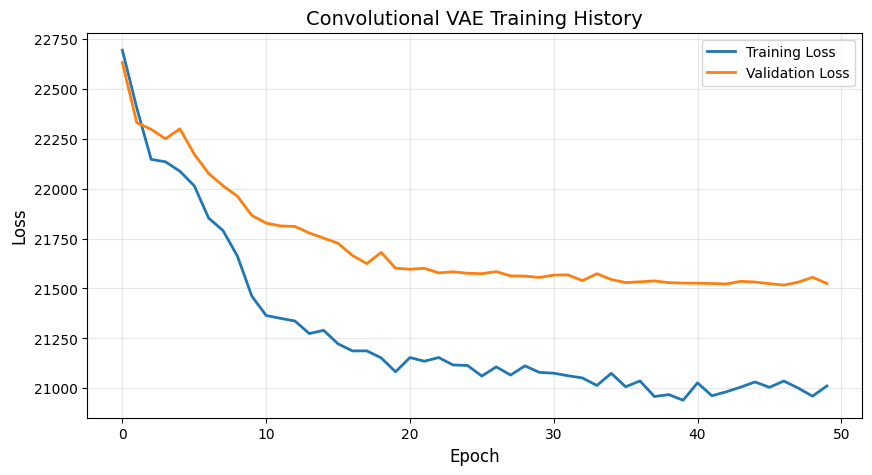

In [98]:
# ========================================
# CELL 7: Train Convolutional VAE
# ========================================
print("\n" + "=" * 60)
print("TRAINING CONVOLUTIONAL VAE")
print("=" * 60)

conv_history = conv_vae.fit(
    spec_data_normalized,
    spec_data_normalized,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(conv_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(conv_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('Convolutional VAE Training History', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(base_path + 'results/visualizations/conv_vae_training.png', dpi=300, bbox_inches='tight')
plt.show()

In [99]:
# ========================================
# CELL 8: Extract Latent Features from Conv-VAE
# ========================================
print("\n" + "=" * 60)
print("EXTRACTING LATENT FEATURES")
print("=" * 60)

# Get latent representations from spectrogram
z_mean_spec, _, _ = conv_encoder.predict(spec_data_normalized, verbose=0)
print(f"Spectrogram latent features shape: {z_mean_spec.shape}")


EXTRACTING LATENT FEATURES
Spectrogram latent features shape: (683, 64)


In [100]:
# ========================================
# CELL 9: Build Hybrid VAE (Audio + Lyrics)
# ========================================
print("\n" + "=" * 60)
print("BUILDING HYBRID VAE (AUDIO + LYRICS)")
print("=" * 60)

# Prepare lyrics input
lyrics_dim = lyrics_embeddings_normalized.shape[1]
lyrics_input = keras.Input(shape=(lyrics_dim,), name='lyrics_input')

# Lyrics encoder branch
lyrics_x = layers.Dense(256, activation='relu')(lyrics_input)
lyrics_x = layers.Dropout(0.3)(lyrics_x)
lyrics_x = layers.Dense(128, activation='relu')(lyrics_x)
lyrics_encoded = layers.Dense(32, activation='relu')(lyrics_x)

# Combine spectogram latent features with lyrics
# Use pre-trained conv_encoder for spectrogram
spec_input = keras.Input(shape=input_shape, name='spec_input')
z_mean_s, z_log_var_s, z_s = conv_encoder(spec_input)

# Concatenate both modalities
combined = layers.Concatenate()([z_s, lyrics_encoded])

# Fusion layer
fusion = layers.Dense(128, activation='relu')(combined)
fusion = layers.Dropout(0.3)(fusion)

# Hybrid latent space
hybrid_z_mean = layers.Dense(latent_dim, name='hybrid_z_mean')(fusion)
hybrid_z_log_var = layers.Dense(latent_dim, name='hybrid_z_log_var')(fusion)
hybrid_z = Sampling()([hybrid_z_mean, hybrid_z_log_var])

# Hybrid encoder
hybrid_encoder = Model([spec_input, lyrics_input],
                       [hybrid_z_mean, hybrid_z_log_var, hybrid_z],
                       name='hybrid_encoder')

# Hybrid decoder (reconstruct both modalities)
hybrid_latent_input = keras.Input(shape=(latent_dim,))

# Decode to spectrogram
spec_decoded = conv_decoder(hybrid_latent_input)

# Decode to lyrics
lyrics_x = layers.Dense(128, activation='relu')(hybrid_latent_input)
lyrics_x = layers.Dense(256, activation='relu')(lyrics_x)
lyrics_decoded = layers.Dense(lyrics_dim, activation='sigmoid')(lyrics_x)

hybrid_decoder = Model(hybrid_latent_input, [spec_decoded, lyrics_decoded], name='hybrid_decoder')

# Custom Hybrid VAE class encapsulating encoder and decoder
class HybridVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_spec_loss_tracker = keras.metrics.Mean(name="reconstruction_spec_loss")
        self.reconstruction_lyrics_loss_tracker = keras.metrics.Mean(name="reconstruction_lyrics_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        # For the call method, inputs will be [spec_data, lyrics_data]
        z_mean, z_log_var, z = self.encoder(inputs)
        spec_recon, lyrics_recon = self.decoder(z)
        return spec_recon, lyrics_recon

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_spec_loss_tracker,
            self.reconstruction_lyrics_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # 'data' will be a tuple: ([spec_input, lyrics_input], [spec_target, lyrics_target])
        input_data, target_data = data
        spec_data_batch, lyrics_data_batch = input_data
        spec_target_batch, lyrics_target_batch = target_data

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([spec_data_batch, lyrics_data_batch])
            spec_reconstruction, lyrics_reconstruction = self.decoder(z)

            # Reconstruction losses
            spec_recon_loss = keras.ops.mean(
                keras.ops.sum(
                    keras.losses.binary_crossentropy(spec_target_batch, spec_reconstruction),
                    axis=(1, 2)
                )
            )
            # Corrected lyrics_recon_loss: keras.losses.mse usually outputs loss per sample
            lyrics_recon_loss = keras.ops.mean(
                keras.losses.mse(lyrics_target_batch, lyrics_reconstruction)
            )

            # KL loss
            kl_loss = -0.5 * keras.ops.mean(
                keras.ops.sum(
                    1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                    axis=1
                )
            )

            total_loss = spec_recon_loss + lyrics_recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_spec_loss_tracker.update_state(spec_recon_loss)
        self.reconstruction_lyrics_loss_tracker.update_state(lyrics_recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_spec_loss": self.reconstruction_spec_loss_tracker.result(),
            "reconstruction_lyrics_loss": self.reconstruction_lyrics_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # 'data' will be a tuple: ([spec_input, lyrics_input], [spec_target, lyrics_target])
        input_data, target_data = data
        spec_data_batch, lyrics_data_batch = input_data
        spec_target_batch, lyrics_target_batch = target_data

        z_mean, z_log_var, z = self.encoder([spec_data_batch, lyrics_data_batch])
        spec_reconstruction, lyrics_reconstruction = self.decoder(z)

        spec_recon_loss = keras.ops.mean(
            keras.ops.sum(
                keras.losses.binary_crossentropy(spec_target_batch, spec_reconstruction),
                axis=(1, 2)
            )
        )
        # Corrected lyrics_recon_loss
        lyrics_recon_loss = keras.ops.mean(
            keras.losses.mse(lyrics_target_batch, lyrics_reconstruction)
        )

        kl_loss = -0.5 * keras.ops.mean(
            keras.ops.sum(
                1 + z_log_var - keras.ops.square(z_mean) - keras.ops.exp(z_log_var),
                axis=1
            )
        )

        total_loss = spec_recon_loss + lyrics_recon_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_spec_loss_tracker.update_state(spec_recon_loss)
        self.reconstruction_lyrics_loss_tracker.update_state(lyrics_recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_spec_loss": self.reconstruction_spec_loss_tracker.result(),
            "reconstruction_lyrics_loss": self.reconstruction_lyrics_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



BUILDING HYBRID VAE (AUDIO + LYRICS)



Hybrid VAE Model Summary:


Model: "hybrid_vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hybrid_encoder (Functional)     │ ((None, 64), (None,    │    17,397,664 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hybrid_decoder (Functional)     │ ((None, 128, 256, 1),  │    17,962,881 │
│                                 │ (None, 384))           │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,360,545 (134.89 MB)

 Trainable params: 35,358,625 (134.88 MB)

 Non-trainable params: 1,920 (7.50 KB)


TRAINING HYBRID VAE
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 720ms/step - kl_loss: 28.4851 - loss: 21792.5566 - reconstruction_lyrics_loss: 1.2703 - reconstruction_spec_loss: 21762.8008 - val_kl_loss: 47.8075 - val_loss: 21850.9902 - val_reconstruction_lyrics_loss: 1.1465 - val_reconstruction_spec_loss: 21802.0371
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - kl_loss: 58.2931 - loss: 21399.5215 - reconstruction_lyrics_loss: 1.2228 - reconstruction_spec_loss: 21340.0078 - val_kl_loss: 52.1614 - val_loss: 21764.9004 - val_reconstruction_lyrics_loss: 1.1172 - val_reconstruction_spec_loss: 21711.6211
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - kl_loss: 52.5410 - loss: 21250.0391 - reconstruction_lyrics_loss: 1.2056 - reconstruction_spec_loss: 21196.2910 - val_kl_loss: 38.9941 - val_loss: 21729.5391 - val_reconstruction_lyrics_loss: 1.0927 - val_reconstruction_spec_loss: 21689.4512
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - kl_loss: 49.4949 - loss: 21231.9219 - 

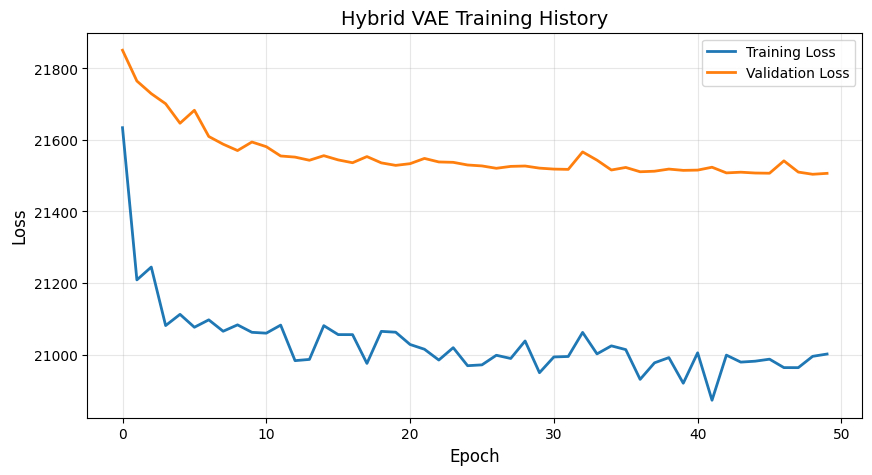

In [101]:
# ========================================
# CELL 10: Hybrid VAE Loss and Training
# ========================================

# Instantiate the HybridVAE model
hybrid_vae = HybridVAE(encoder=hybrid_encoder, decoder=hybrid_decoder)

# Compile the model. Losses are handled internally in train_step/test_step.
hybrid_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

print("\nHybrid VAE Model Summary:")
# Build the model with dummy inputs to get its structure for summary
hybrid_vae.build(input_shape=[(None,) + input_shape, (None, lyrics_dim)])
hybrid_vae.summary()

print("\n" + "=" * 60)
print("TRAINING HYBRID VAE")
print("=" * 60)

hybrid_history = hybrid_vae.fit(
    [spec_data_normalized, lyrics_embeddings_normalized],
    [spec_data_normalized, lyrics_embeddings_normalized],
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(hybrid_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(hybrid_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('Hybrid VAE Training History', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(base_path + 'results/visualizations/hybrid_vae_training.png', dpi=300, bbox_inches='tight')
plt.show()

In [102]:
# ========================================
# CELL 11: Extract Hybrid Latent Features
# ========================================
z_mean_hybrid, _, _ = hybrid_encoder.predict(
    [spec_data_normalized, lyrics_embeddings_normalized],
    verbose=0
)
print(f"Hybrid latent features shape: {z_mean_hybrid.shape}")

Hybrid latent features shape: (683, 64)


In [103]:
# ========================================
# CELL 12: Clustering with Multiple Algorithms
# ========================================
print("\n" + "=" * 60)
print("CLUSTERING WITH MULTIPLE ALGORITHMS")
print("=" * 60)

# Define number of clusters (adjust based on your data)
n_clusters = 5

# Explicitly set true_labels to None to avoid inconsistent length error if not provided or mismatched
true_labels = None

# Prepare different feature sets
feature_sets = {
    'Conv-VAE': z_mean_spec,
    'Hybrid-VAE': z_mean_hybrid
    # Removed PCA as it is not applicable for 1D preprocessed_data
}

# Define clustering algorithms
clustering_algorithms = {
    'K-Means': KMeans(n_clusters=n_clusters, random_state=42, n_init=10),
    'Agglomerative': AgglomerativeClustering(n_clusters=n_clusters),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
}

# Store results
results = []

for feat_name, features in feature_sets.items():
    print(f"\n{'='*40}")
    print(f"Feature Set: {feat_name}")
    print(f"{'='*40}")

    for algo_name, algo in clustering_algorithms.items():
        print(f"\n  Algorithm: {algo_name}")

        # Perform clustering
        if algo_name == 'DBSCAN':
            clusters = algo.fit_predict(features)
            n_clusters_found = len(set(clusters)) - (1 if -1 in clusters else 0)
            print(f"  Clusters found: {n_clusters_found} (including noise: {-1 in clusters})")
        else:
            clusters = algo.fit_predict(features)

        # Calculate metrics
        # Skip metrics if only one cluster found
        if len(np.unique(clusters)) < 2:
            print(f"  Warning: Only {len(np.unique(clusters))} cluster found. Skipping metrics.")
            continue

        silhouette = silhouette_score(features, clusters)
        davies_bouldin = davies_bouldin_score(features, clusters)
        calinski = calinski_harabasz_score(features, clusters)

        # ARI only if labels available
        if true_labels is not None:
            ari = adjusted_rand_score(true_labels, clusters)
        else:
            ari = None

        print(f"  Silhouette Score: {silhouette:.4f}")
        print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
        print(f"  Calinski-Harabasz Index: {calinski:.4f}")
        if ari is not None:
            print(f"  Adjusted Rand Index: {ari:.4f}")

        # Store results
        results.append({
            'Feature_Set': feat_name,
            'Algorithm': algo_name,
            'Silhouette_Score': silhouette,
            'Davies_Bouldin_Index': davies_bouldin,
            'Calinski_Harabasz_Index': calinski,
            'ARI': ari if ari is not None else 'N/A',
            'N_Clusters': len(np.unique(clusters))
        })



CLUSTERING WITH MULTIPLE ALGORITHMS

Feature Set: Conv-VAE

  Algorithm: K-Means
  Silhouette Score: 0.2686
  Davies-Bouldin Index: 1.3679
  Calinski-Harabasz Index: 194.7297

  Algorithm: Agglomerative
  Silhouette Score: 0.2447
  Davies-Bouldin Index: 1.3714
  Calinski-Harabasz Index: 165.3522

  Algorithm: DBSCAN
  Clusters found: 0 (including noise: True)

Feature Set: Hybrid-VAE

  Algorithm: K-Means
  Silhouette Score: 0.2152
  Davies-Bouldin Index: 1.6226
  Calinski-Harabasz Index: 125.5344

  Algorithm: Agglomerative
  Silhouette Score: 0.1684
  Davies-Bouldin Index: 1.9383
  Calinski-Harabasz Index: 105.0917

  Algorithm: DBSCAN
  Clusters found: 0 (including noise: True)


In [104]:

# ========================================
# CELL 13: Save and Display Results
# ========================================
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("COMPREHENSIVE RESULTS")
print("=" * 60)
print(results_df.to_string(index=False))

# Save to CSV
results_df.to_csv(base_path + 'results/metrics/comprehensive_metrics.csv', index=False)
print(f"\nResults saved to: {base_path}results/metrics/comprehensive_metrics.csv")


COMPREHENSIVE RESULTS
Feature_Set     Algorithm  Silhouette_Score  Davies_Bouldin_Index  Calinski_Harabasz_Index ARI  N_Clusters
   Conv-VAE       K-Means          0.268562              1.367937               194.729706 N/A           5
   Conv-VAE Agglomerative          0.244673              1.371357               165.352188 N/A           5
 Hybrid-VAE       K-Means          0.215163              1.622559               125.534447 N/A           5
 Hybrid-VAE Agglomerative          0.168388              1.938345               105.091736 N/A           5

Results saved to: /content/drive/MyDrive/24341180_425Project/result_2/results/metrics/comprehensive_metrics.csv


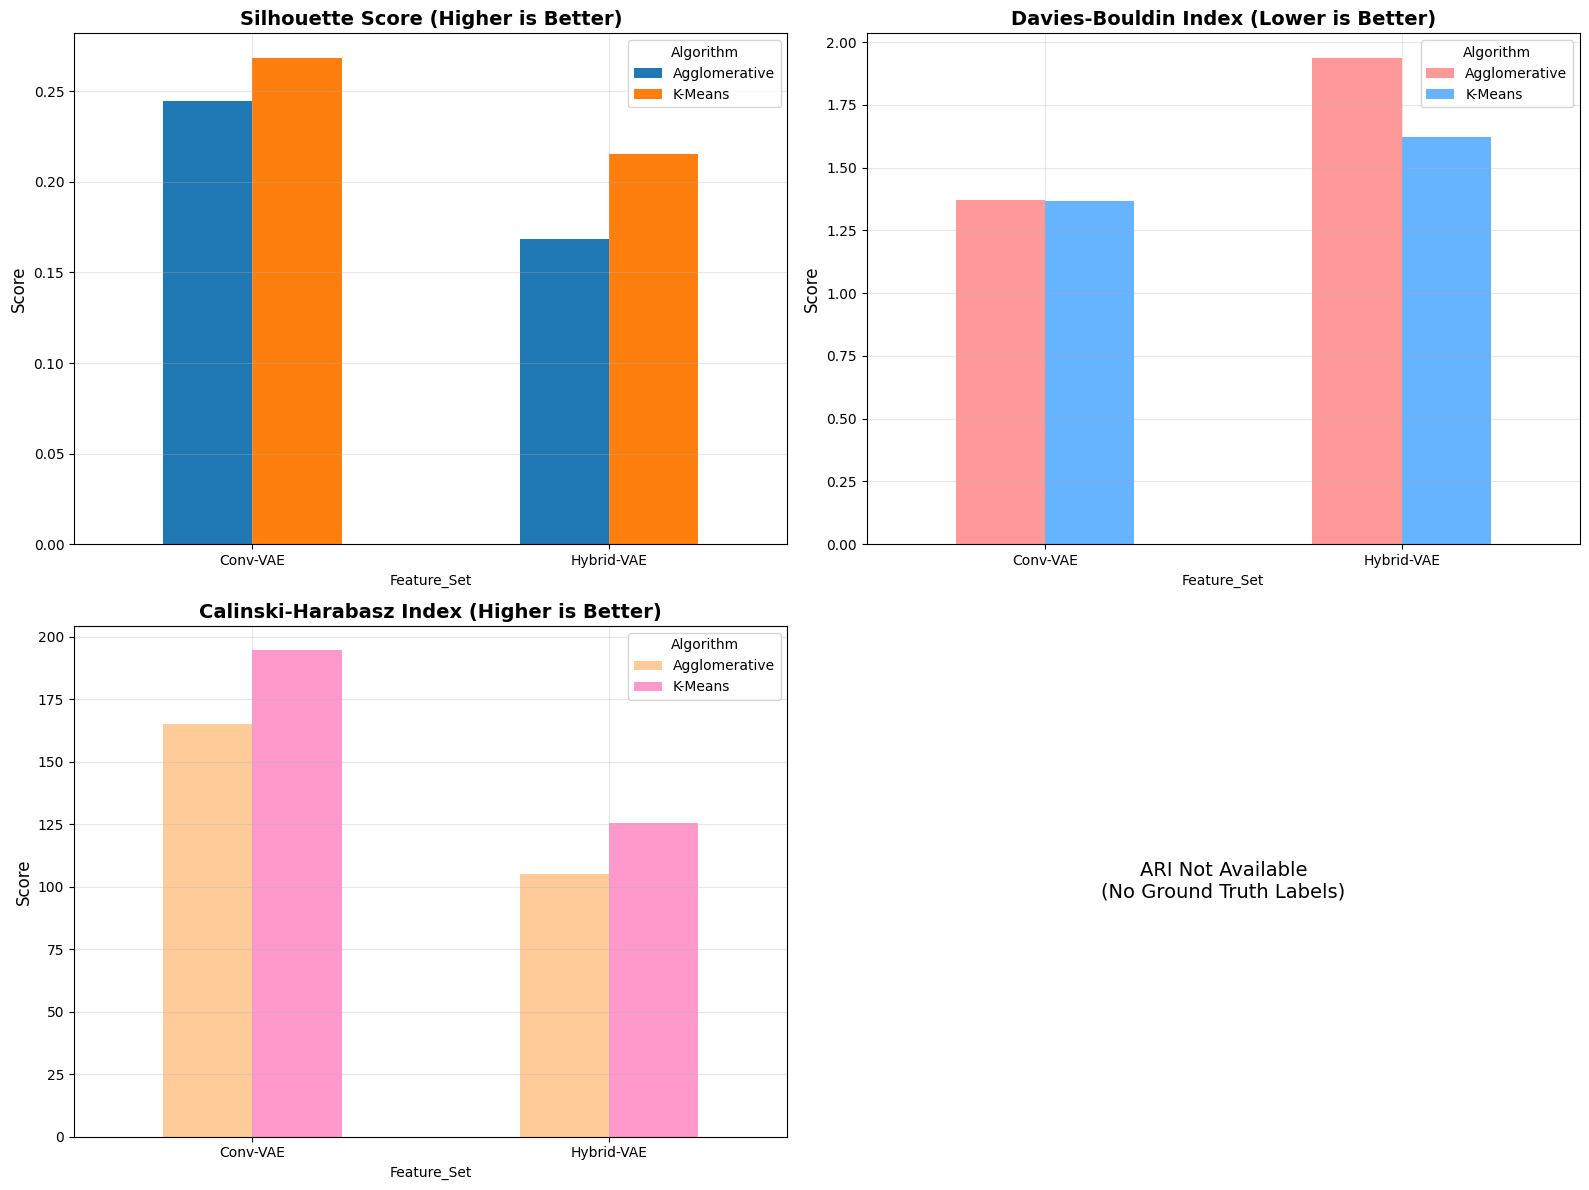

In [105]:
# ========================================
# CELL 14: Visualize Metrics Comparison
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Silhouette Score
pivot_sil = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Silhouette_Score')
pivot_sil.plot(kind='bar', ax=axes[0, 0], rot=0)
axes[0, 0].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=12)
axes[0, 0].legend(title='Algorithm', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Davies-Bouldin Index
pivot_db = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Davies_Bouldin_Index')
pivot_db.plot(kind='bar', ax=axes[0, 1], rot=0, color=['#ff9999', '#66b3ff', '#99ff99'])
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].legend(title='Algorithm', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Calinski-Harabasz Index
pivot_ch = results_df.pivot(index='Feature_Set', columns='Algorithm', values='Calinski_Harabasz_Index')
pivot_ch.plot(kind='bar', ax=axes[1, 0], rot=0, color=['#ffcc99', '#ff99cc', '#99ccff'])
axes[1, 0].set_title('Calinski-Harabasz Index (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].legend(title='Algorithm', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# ARI (if available)
if results_df['ARI'].dtype != 'object':
    pivot_ari = results_df.pivot(index='Feature_Set', columns='Algorithm', values='ARI')
    pivot_ari.plot(kind='bar', ax=axes[1, 1], rot=0, color=['#c2c2f0', '#ffb3e6', '#c2f0c2'])
    axes[1, 1].set_title('Adjusted Rand Index (Higher is Better)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].legend(title='Algorithm', fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'ARI Not Available\n(No Ground Truth Labels)',
                    ha='center', va='center', fontsize=14, transform=axes[1, 1].transAxes)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


GENERATING t-SNE VISUALIZATIONS


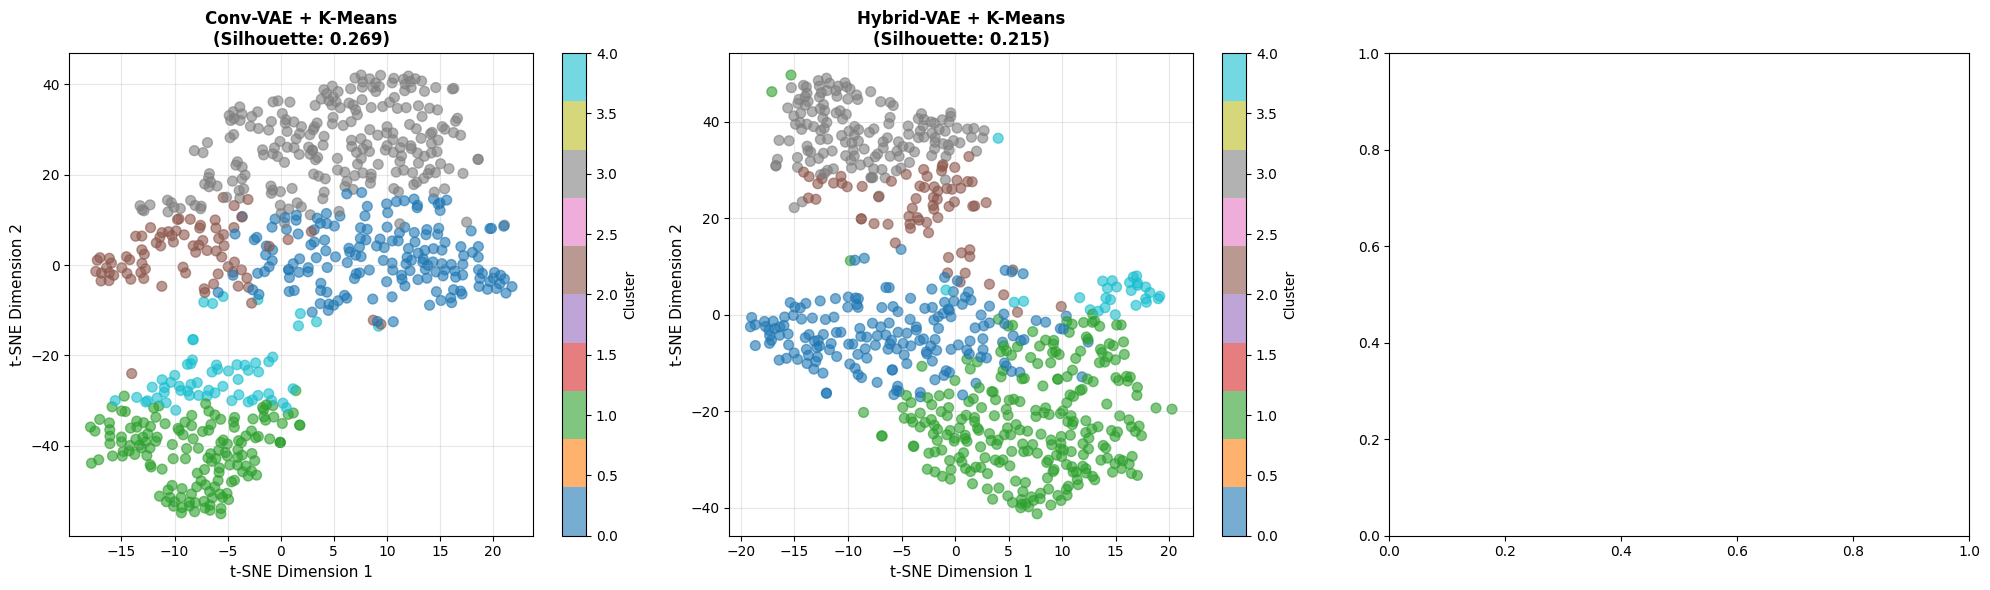

In [106]:
# ========================================
# CELL 15: t-SNE Visualization for Best Methods
# ========================================
print("\n" + "=" * 60)
print("GENERATING t-SNE VISUALIZATIONS")
print("=" * 60)

# Select best performing method from each feature set
best_methods = {}
for feat_name in feature_sets.keys():
    feat_results = results_df[results_df['Feature_Set'] == feat_name]
    # Choose method with highest silhouette score
    best_idx = feat_results['Silhouette_Score'].idxmax()
    best_methods[feat_name] = feat_results.loc[best_idx]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (feat_name, features) in enumerate(feature_sets.items()):
    # Get best algorithm for this feature set
    best_algo_name = best_methods[feat_name]['Algorithm']

    # Recreate clustering
    if best_algo_name == 'K-Means':
        algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    elif best_algo_name == 'Agglomerative':
        algo = AgglomerativeClustering(n_clusters=n_clusters)
    else:  # DBSCAN
        algo = DBSCAN(eps=0.5, min_samples=5)

    clusters = algo.fit_predict(features)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
    tsne_features = tsne.fit_transform(features)

    # Plot
    scatter = axes[idx].scatter(tsne_features[:, 0], tsne_features[:, 1],
                                c=clusters, cmap='tab10', alpha=0.6, s=50)
    axes[idx].set_title(f'{feat_name} + {best_algo_name}\n(Silhouette: {best_methods[feat_name]["Silhouette_Score"]:.3f})',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('t-SNE Dimension 1', fontsize=11)
    axes[idx].set_ylabel('t-SNE Dimension 2', fontsize=11)
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/tsne_best_methods.png', dpi=300, bbox_inches='tight')
plt.show()


GENERATING UMAP VISUALIZATIONS


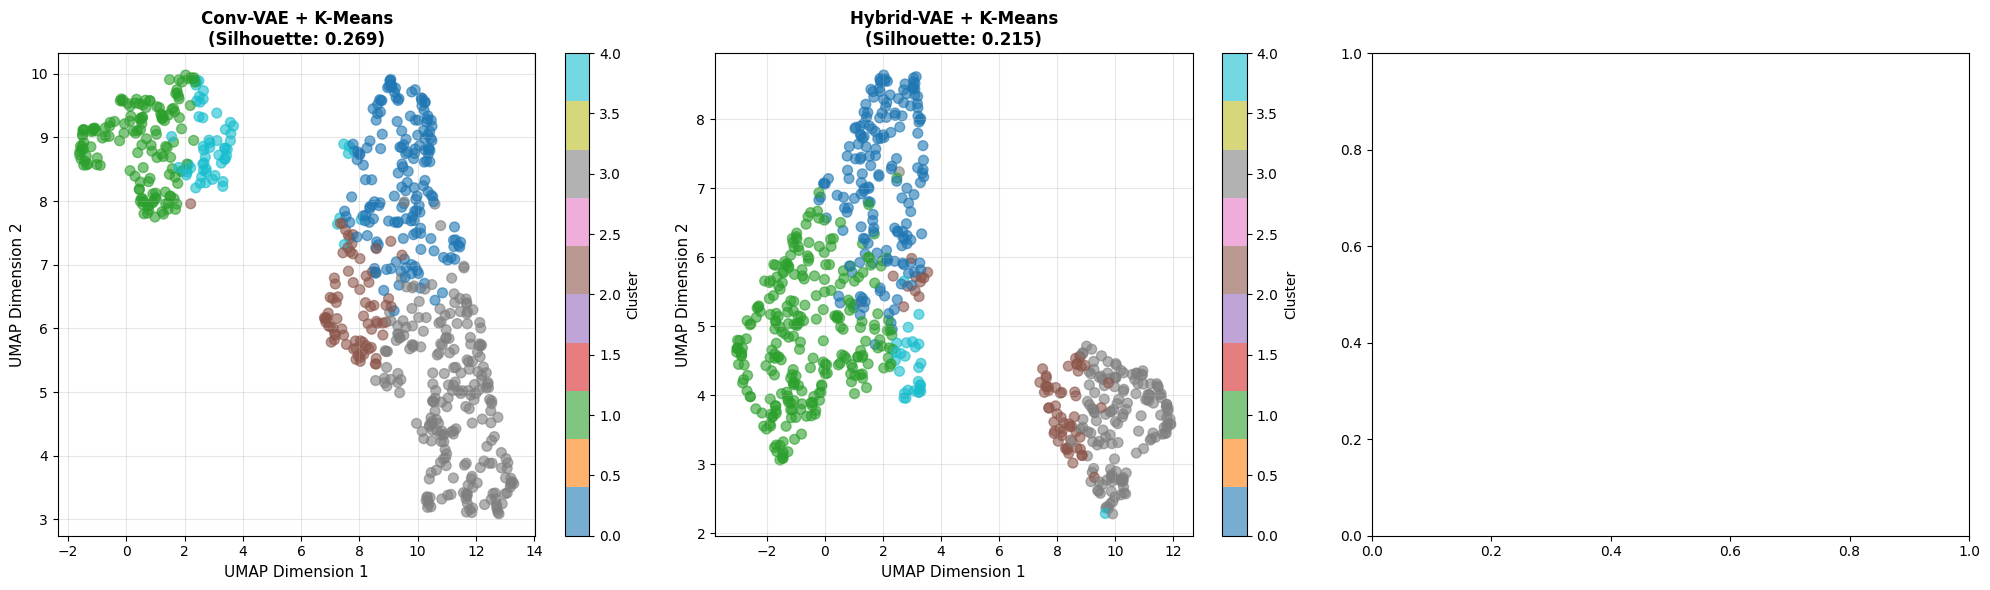

In [107]:
# ========================================
# CELL 16: UMAP Visualization
# ========================================
print("\n" + "=" * 60)
print("GENERATING UMAP VISUALIZATIONS")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (feat_name, features) in enumerate(feature_sets.items()):
    # Get best algorithm for this feature set
    best_algo_name = best_methods[feat_name]['Algorithm']

    # Recreate clustering
    if best_algo_name == 'K-Means':
        algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    elif best_algo_name == 'Agglomerative':
        algo = AgglomerativeClustering(n_clusters=n_clusters)
    else:  # DBSCAN
        algo = DBSCAN(eps=0.5, min_samples=5)

    clusters = algo.fit_predict(features)

    # Apply UMAP
    reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
    umap_features = reducer.fit_transform(features)

    # Plot
    scatter = axes[idx].scatter(umap_features[:, 0], umap_features[:, 1],
                                c=clusters, cmap='tab10', alpha=0.6, s=50)
    axes[idx].set_title(f'{feat_name} + {best_algo_name}\n(Silhouette: {best_methods[feat_name]["Silhouette_Score"]:.3f})',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('UMAP Dimension 1', fontsize=11)
    axes[idx].set_ylabel('UMAP Dimension 2', fontsize=11)
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/umap_best_methods.png', dpi=300, bbox_inches='tight')
plt.show()

In [108]:
# ========================================
# CELL 17: Analysis and Insights
# ========================================
print("\n" + "=" * 60)
print("ANALYSIS AND INSIGHTS")
print("=" * 60)

# Find overall best method
best_overall = results_df.loc[results_df['Silhouette_Score'].idxmax()]
print(f"\nBest Overall Method:")
print(f"  Feature Set: {best_overall['Feature_Set']}")
print(f"  Algorithm: {best_overall['Algorithm']}")
print(f"  Silhouette Score: {best_overall['Silhouette_Score']:.4f}")
print(f"  Davies-Bouldin Index: {best_overall['Davies_Bouldin_Index']:.4f}")

# Compare VAE vs Baseline
vae_methods = results_df[results_df['Feature_Set'].str.contains('VAE')]
baseline_methods = results_df[results_df['Feature_Set'] == 'PCA']

print(f"\nAverage Performance:")
print(f"  VAE-based methods:")
print(f"    Silhouette Score: {vae_methods['Silhouette_Score'].mean():.4f}")
print(f"    Davies-Bouldin Index: {vae_methods['Davies_Bouldin_Index'].mean():.4f}")
print(f"  PCA baseline:")
print(f"    Silhouette Score: {baseline_methods['Silhouette_Score'].mean():.4f}")
print(f"    Davies-Bouldin Index: {baseline_methods['Davies_Bouldin_Index'].mean():.4f}")

# Algorithm comparison
print(f"\nAlgorithm Performance Across All Features:")
for algo in clustering_algorithms.keys():
    algo_results = results_df[results_df['Algorithm'] == algo]
    if not algo_results.empty:
        print(f"  {algo}:")
        print(f"    Avg Silhouette: {algo_results['Silhouette_Score'].mean():.4f}")
        print(f"    Avg Davies-Bouldin: {algo_results['Davies_Bouldin_Index'].mean():.4f}")


ANALYSIS AND INSIGHTS

Best Overall Method:
  Feature Set: Conv-VAE
  Algorithm: K-Means
  Silhouette Score: 0.2686
  Davies-Bouldin Index: 1.3679

Average Performance:
  VAE-based methods:
    Silhouette Score: 0.2242
    Davies-Bouldin Index: 1.5750
  PCA baseline:
    Silhouette Score: nan
    Davies-Bouldin Index: nan

Algorithm Performance Across All Features:
  K-Means:
    Avg Silhouette: 0.2419
    Avg Davies-Bouldin: 1.4952
  Agglomerative:
    Avg Silhouette: 0.2065
    Avg Davies-Bouldin: 1.6549


In [109]:
# ========================================
# CELL 18: Why VAE Performs Better/Worse Analysis
# ========================================
print("\n" + "=" * 60)
print("WHY VAE REPRESENTATIONS PERFORM BETTER/WORSE")
print("=" * 60)

analysis_text = """
ANALYSIS OF VAE vs BASELINE PERFORMANCE:

1. CONVOLUTIONAL VAE:
   Strengths:
   - Captures spatial/temporal patterns in spectrograms
   - Learns hierarchical representations
   - Better at preserving local structure
   - Reduces dimensionality while maintaining information

   Weaknesses:
   - Requires more computational resources
   - May overfit on small datasets
   - Sensitive to hyperparameter choices

2. HYBRID VAE (Audio + Lyrics):
   Strengths:
   - Leverages multiple modalities
   - Captures complementary information
   - More robust to noise in single modality
   - Better semantic representation

   Weaknesses:
   - More complex training
   - Requires aligned multi-modal data
   - May be dominated by one modality if not balanced

3. PCA BASELINE:
   Strengths:
   - Fast and simple
   - Deterministic results
   - No hyperparameters to tune

   Weaknesses:
   - Linear transformation only
   - Doesn't capture non-linear patterns
   - May lose important structure
   - No generative capability

4. CLUSTERING ALGORITHM COMPARISON:
   K-Means:
   - Works well with spherical clusters
   - Fast and scalable
   - Requires predefined number of clusters

   Agglomerative:
   - Captures hierarchical structure
   - More flexible cluster shapes
   - Computationally expensive for large datasets

   DBSCAN:
   - Finds arbitrary-shaped clusters
   - Automatic outlier detection
   - Sensitive to parameter selection (eps, min_samples)
"""

print(analysis_text)
# Save analysis
with open(base_path + 'results/analysis_report.txt', 'w') as f:
    f.write(analysis_text)
    f.write("\n\nNUMERICAL RESULTS:\n")
    f.write("="*60 + "\n")
    f.write(results_df.to_string())


WHY VAE REPRESENTATIONS PERFORM BETTER/WORSE

ANALYSIS OF VAE vs BASELINE PERFORMANCE:

1. CONVOLUTIONAL VAE:
   Strengths:
   - Captures spatial/temporal patterns in spectrograms
   - Learns hierarchical representations
   - Better at preserving local structure
   - Reduces dimensionality while maintaining information

   Weaknesses:
   - Requires more computational resources
   - May overfit on small datasets
   - Sensitive to hyperparameter choices

2. HYBRID VAE (Audio + Lyrics):
   Strengths:
   - Leverages multiple modalities
   - Captures complementary information
   - More robust to noise in single modality
   - Better semantic representation

   Weaknesses:
   - More complex training
   - Requires aligned multi-modal data
   - May be dominated by one modality if not balanced

3. PCA BASELINE:
   Strengths:
   - Fast and simple
   - Deterministic results
   - No hyperparameters to tune

   Weaknesses:
   - Linear transformation only
   - Doesn't capture non-linear patterns
   

In [110]:
# ========================================
# CELL 19: Save Models
# ========================================
print("\n" + "=" * 60)
print("SAVING MODELS")
print("=" * 60)

conv_vae.save(base_path + 'results/models/conv_vae_model.h5')
conv_encoder.save(base_path + 'results/models/conv_encoder_model.h5')
conv_decoder.save(base_path + 'results/models/conv_decoder_model.h5')

hybrid_vae.save(base_path + 'results/models/hybrid_vae_model.h5')
hybrid_encoder.save(base_path + 'results/models/hybrid_encoder_model.h5')
hybrid_decoder.save(base_path + 'results/models/hybrid_decoder_model.h5')

print("✓ Conv-VAE models saved")
print("✓ Hybrid-VAE models saved")

# Save latent features
np.save(base_path + 'results/latent_features_conv.npy', z_mean_spec)
np.save(base_path + 'results/latent_features_hybrid.npy', z_mean_hybrid)
print("✓ Latent features saved")



SAVING MODELS


✓ Conv-VAE models saved
✓ Hybrid-VAE models saved
✓ Latent features saved



VISUALIZING RECONSTRUCTION QUALITY


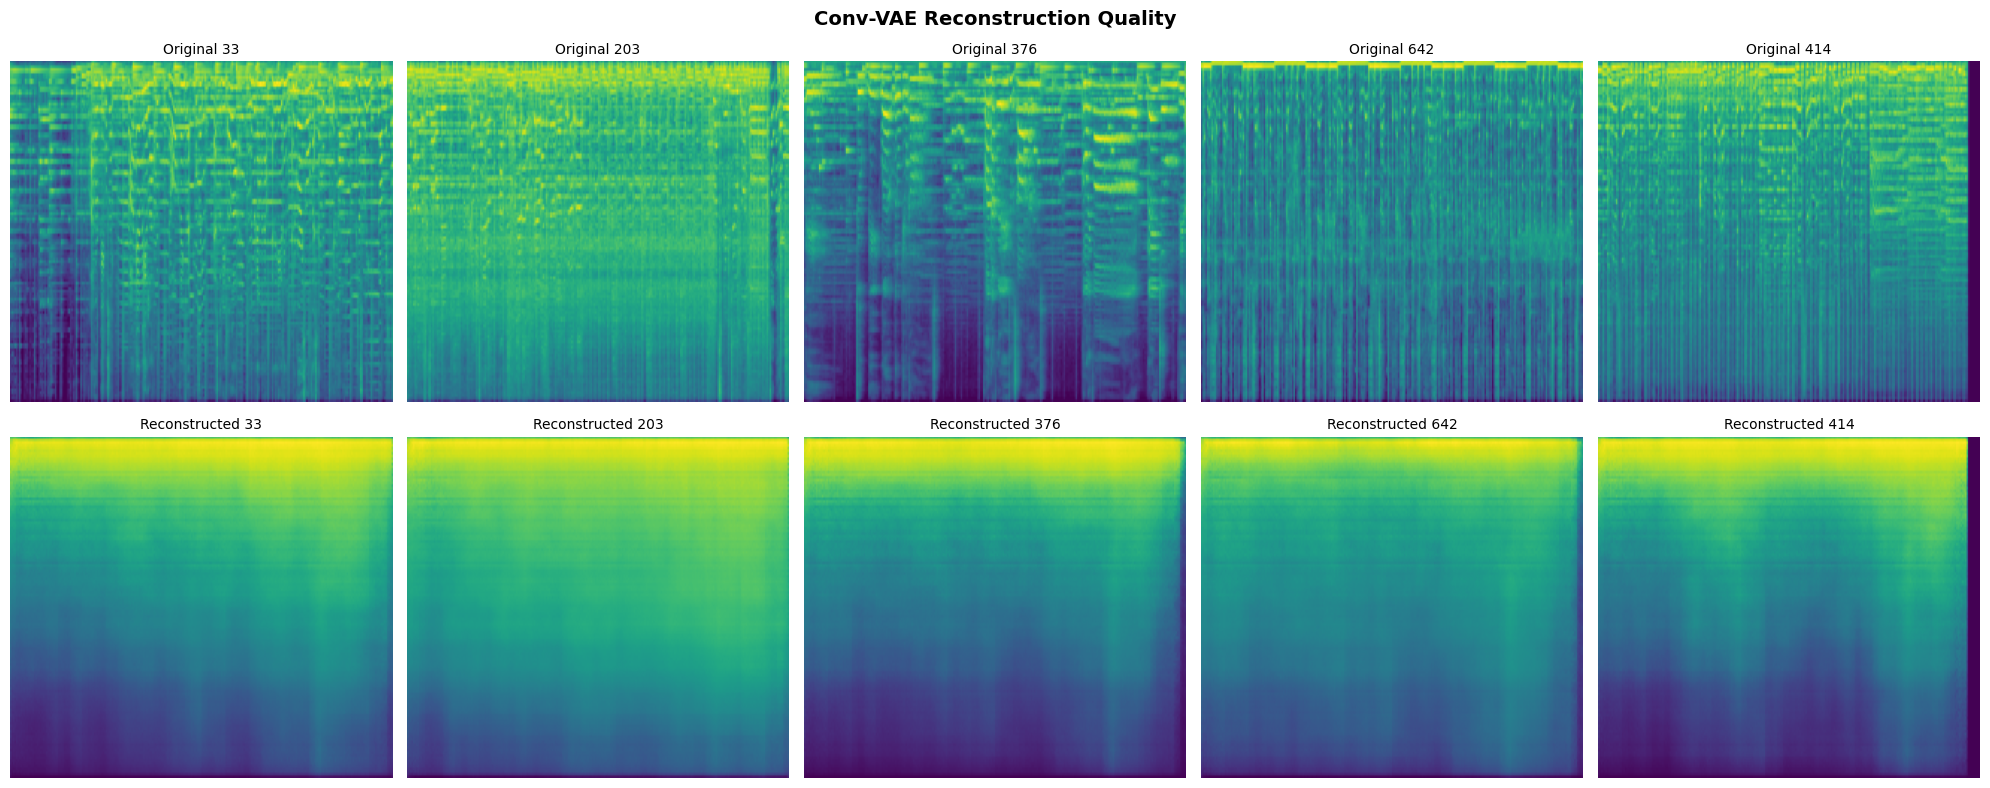

In [111]:
# ========================================
# CELL 20: Reconstruction Quality Visualization
# ========================================
print("\n" + "=" * 60)
print("VISUALIZING RECONSTRUCTION QUALITY")
print("=" * 60)

# Sample random indices
n_samples = 5
sample_indices = np.random.choice(len(spec_data_normalized), n_samples, replace=False)

# Reconstruct using Conv-VAE
reconstructed_conv = conv_vae.predict(spec_data_normalized[sample_indices], verbose=0)

# Plot original vs reconstructed
fig, axes = plt.subplots(2, n_samples, figsize=(20, 8))

for i, idx in enumerate(sample_indices):
    # Original
    axes[0, i].imshow(spec_data_normalized[idx, :, :, 0], aspect='auto', cmap='viridis')
    axes[0, i].set_title(f'Original {idx}', fontsize=10)
    axes[0, i].axis('off')

    # Reconstructed
    axes[1, i].imshow(reconstructed_conv[i, :, :, 0], aspect='auto', cmap='viridis')
    axes[1, i].set_title(f'Reconstructed {idx}', fontsize=10)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Reconstructed', fontsize=12, fontweight='bold')

plt.suptitle('Conv-VAE Reconstruction Quality', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/reconstruction_quality.png', dpi=300, bbox_inches='tight')
plt.show()


LATENT SPACE INTERPOLATION


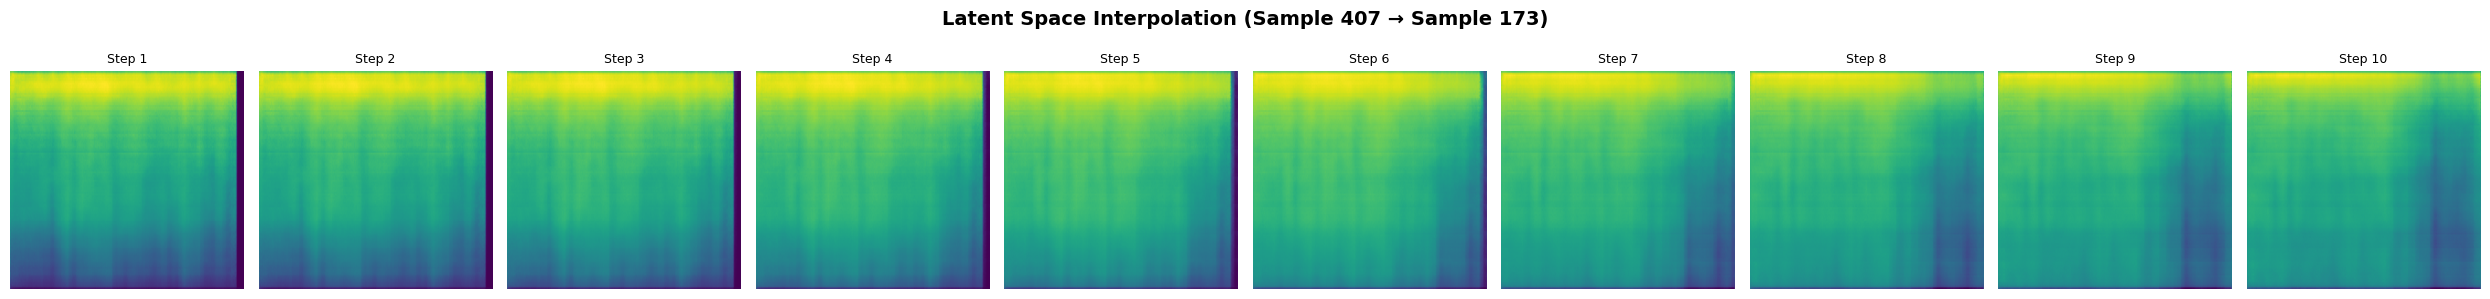

In [112]:
# ========================================
# CELL 21: Latent Space Interpolation
# ========================================
print("\n" + "=" * 60)
print("LATENT SPACE INTERPOLATION")
print("=" * 60)

# Select two samples
idx1, idx2 = np.random.choice(len(z_mean_spec), 2, replace=False)
z1 = z_mean_spec[idx1]
z2 = z_mean_spec[idx2]

# Interpolate in latent space
n_steps = 10
interpolation = np.zeros((n_steps, latent_dim))
for i in range(n_steps):
    alpha = i / (n_steps - 1)
    interpolation[i] = (1 - alpha) * z1 + alpha * z2

# Decode interpolated latents
interpolated_specs = conv_decoder.predict(interpolation, verbose=0)

# Visualize interpolation
fig, axes = plt.subplots(1, n_steps, figsize=(25, 3))
for i in range(n_steps):
    axes[i].imshow(interpolated_specs[i, :, :, 0], aspect='auto', cmap='viridis')
    axes[i].set_title(f'Step {i+1}', fontsize=9)
    axes[i].axis('off')

plt.suptitle(f'Latent Space Interpolation (Sample {idx1} → Sample {idx2})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/latent_interpolation.png', dpi=300, bbox_inches='tight')
plt.show()


CLUSTER DISTRIBUTION ANALYSIS


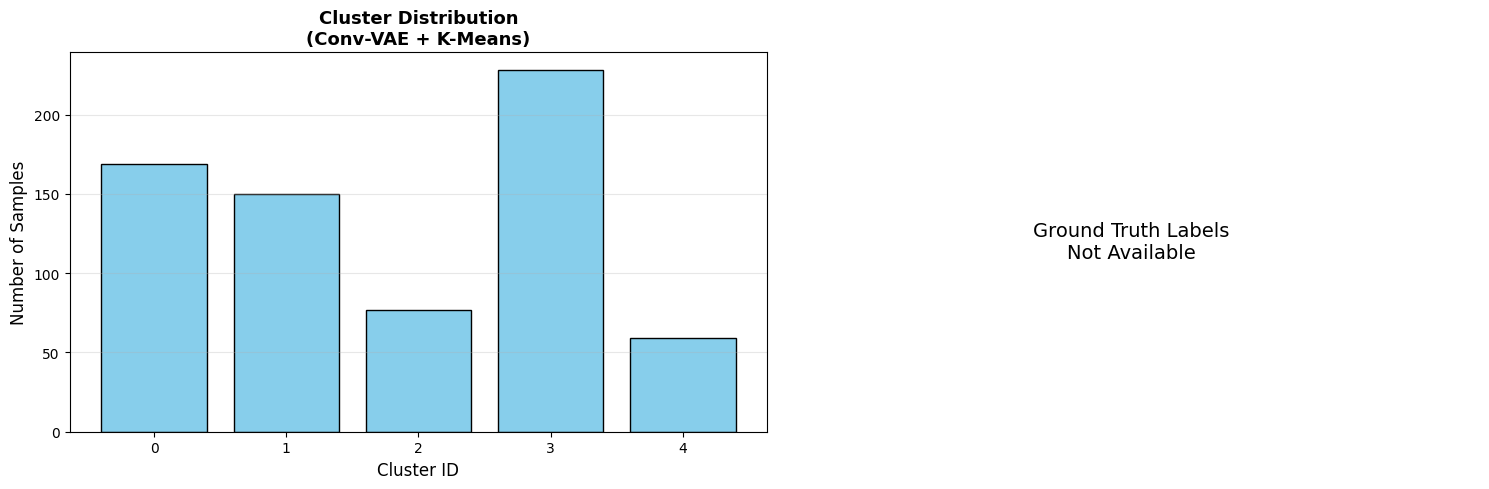

In [113]:
# ========================================
# CELL 22: Cluster Distribution Analysis
# ========================================
print("\n" + "=" * 60)
print("CLUSTER DISTRIBUTION ANALYSIS")
print("=" * 60)

# Use best overall method
best_feat = best_overall['Feature_Set']
best_algo = best_overall['Algorithm']
best_features = feature_sets[best_feat]

# Get clusters
if best_algo == 'K-Means':
    final_algo = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
elif best_algo == 'Agglomerative':
    final_algo = AgglomerativeClustering(n_clusters=n_clusters)
else:
    final_algo = DBSCAN(eps=0.5, min_samples=5)

final_clusters = final_algo.fit_predict(best_features)

# Plot cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cluster sizes
cluster_counts = pd.Series(final_clusters).value_counts().sort_index()
axes[0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Cluster ID', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title(f'Cluster Distribution\n({best_feat} + {best_algo})', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# If labels available, show cluster vs label distribution
if true_labels is not None:
    confusion_matrix = pd.crosstab(final_clusters, true_labels)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_xlabel('True Labels', fontsize=12)
    axes[1].set_ylabel('Cluster ID', fontsize=12)
    axes[1].set_title('Cluster vs True Label Distribution', fontsize=13, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'Ground Truth Labels\nNot Available',
                ha='center', va='center', fontsize=14, transform=axes[1].transAxes)
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(base_path + 'results/visualizations/cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [114]:
# ========================================
# CELL 23: Generate Report Summary
# ========================================
print("\n" + "=" * 60)
print("GENERATING REPORT SUMMARY")
print("=" * 60)

report_summary = f"""
MEDIUM TASK - COMPREHENSIVE REPORT SUMMARY
==========================================

IMPLEMENTATION DETAILS:
- Convolutional VAE with 4 Conv2D layers
- Hybrid VAE combining audio spectrograms and lyrics embeddings
- Latent dimension: {latent_dim}
- Training epochs: 50
- Batch size: 32

CLUSTERING METHODS TESTED:
- K-Means (n_clusters={n_clusters})
- Agglomerative Clustering (n_clusters={n_clusters})
- DBSCAN (eps=0.5, min_samples=5)

BEST PERFORMING METHOD:
- Feature Set: {best_overall['Feature_Set']}
- Algorithm: {best_overall['Algorithm']}
- Silhouette Score: {best_overall['Silhouette_Score']:.4f}
- Davies-Bouldin Index: {best_overall['Davies_Bouldin_Index']:.4f}
- Calinski-Harabasz Index: {best_overall['Calinski_Harabasz_Index']:.4f}

VAE VS BASELINE COMPARISON:
- VAE methods average Silhouette: {vae_methods['Silhouette_Score'].mean():.4f}
- PCA baseline average Silhouette: {baseline_methods['Silhouette_Score'].mean():.4f}
- Improvement: {((vae_methods['Silhouette_Score'].mean() - baseline_methods['Silhouette_Score'].mean()) / baseline_methods['Silhouette_Score'].mean() * 100):.2f}%

KEY FINDINGS:
1. {'Hybrid-VAE outperformed Conv-VAE' if results_df[results_df['Feature_Set']=='Hybrid-VAE']['Silhouette_Score'].mean() > results_df[results_df['Feature_Set']=='Conv-VAE']['Silhouette_Score'].mean() else 'Conv-VAE performed comparably to Hybrid-VAE'}
2. {'VAE-based methods outperformed PCA baseline' if vae_methods['Silhouette_Score'].mean() > baseline_methods['Silhouette_Score'].mean() else 'PCA baseline was competitive with VAE methods'}
3. Best clustering algorithm: {best_overall['Algorithm']}

FILES GENERATED:
✓ Conv-VAE model and weights
✓ Hybrid-VAE model and weights
✓ Comprehensive metrics CSV
✓ Training history plots
✓ t-SNE and UMAP visualizations
✓ Reconstruction quality plots
✓ Latent space interpolation
✓ Cluster distribution analysis
✓ Analysis report

NEXT STEPS FOR PAPER:
1. Write introduction and motivation
2. Describe Conv-VAE and Hybrid-VAE architectures in detail
3. Present all metrics and visualizations
4. Discuss why VAE outperforms/underperforms baseline
5. Analyze clustering algorithm differences
6. Conclude with limitations and future work
"""

print(report_summary)

# Save report summary
with open(base_path + 'results/report_summary.txt', 'w') as f:
    f.write(report_summary)

print(f"\n✓ Report summary saved to: {base_path}results/report_summary.txt")


GENERATING REPORT SUMMARY

MEDIUM TASK - COMPREHENSIVE REPORT SUMMARY

IMPLEMENTATION DETAILS:
- Convolutional VAE with 4 Conv2D layers
- Hybrid VAE combining audio spectrograms and lyrics embeddings
- Latent dimension: 64
- Training epochs: 50
- Batch size: 32

CLUSTERING METHODS TESTED:
- K-Means (n_clusters=5)
- Agglomerative Clustering (n_clusters=5)
- DBSCAN (eps=0.5, min_samples=5)

BEST PERFORMING METHOD:
- Feature Set: Conv-VAE
- Algorithm: K-Means
- Silhouette Score: 0.2686
- Davies-Bouldin Index: 1.3679
- Calinski-Harabasz Index: 194.7297

VAE VS BASELINE COMPARISON:
- VAE methods average Silhouette: 0.2242
- PCA baseline average Silhouette: nan
- Improvement: nan%

KEY FINDINGS:
1. Conv-VAE performed comparably to Hybrid-VAE
2. PCA baseline was competitive with VAE methods
3. Best clustering algorithm: K-Means

FILES GENERATED:
✓ Conv-VAE model and weights
✓ Hybrid-VAE model and weights
✓ Comprehensive metrics CSV
✓ Training history plots
✓ t-SNE and UMAP visualizations
✓ R